In [ ]:
# Training data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

# Validation data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-09-15 13:55:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  63.7MB/s    in 2.2s    

2020-09-15 13:55:32 (63.7 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-09-15 13:55:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [ ]:
import os 
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human/training')
zip_ref.close()

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human/validation')
zip_ref.close()

In [ ]:
base_dir = '/tmp/horse-or-human'
training_dir = base_dir + '/training'
validation_dir = base_dir + '/validation'

training_horse_dir = training_dir + '/horses'
training_human_dir = training_dir + '/humans'

validation_horse_dir = validation_dir + '/horses'
validation_human_dir = validation_dir + '/humans'

print("Training Horse Images: ", len(os.listdir(training_horse_dir)))
print("Training Human Images: ", len(os.listdir(training_human_dir)))
print("Validation Horse Images: ", len(os.listdir(validation_horse_dir)))
print("Validation Human Images: ", len(os.listdir(validation_human_dir)))

Training Horse Images:  500
Training Human Images:  527
Validation Horse Images:  128
Validation Human Images:  128


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

pic_index = 0

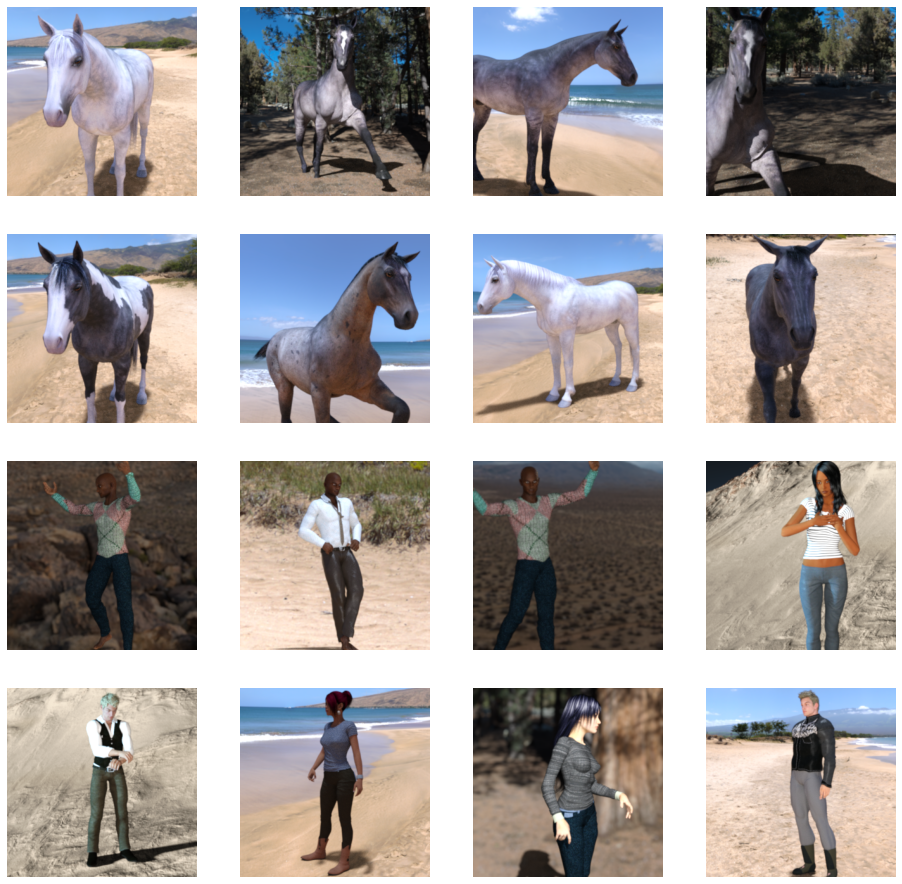

In [ ]:
fig = plt.gcf()
fig.set_size_inches(nrows*4,ncols*4)

pic_index += 8

next_horse_index = [os.path.join(training_horse_dir, fname) for fname in os.listdir(training_horse_dir)[pic_index-8:pic_index]]
next_human_index = [os.path.join(training_human_dir, fname) for fname in os.listdir(training_human_dir)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_index+next_human_index):
  sp = plt.subplot(nrows,ncols,i+1)
  sp.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=(150,150),
                                                    batch_size=50,
                                                    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150,150),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights='imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output: ", last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step
Last layer output:  (None, 7, 7, 768)


In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
                              pre_trained_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(1024, activation="relu"),
                              tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,679,201
Trainable params: 18,876,417
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.0001),
              loss="binary_crossentropy",
              metrics=["acc"])

In [ ]:
history = model.fit(train_generator,
          steps_per_epoch=21,
          epochs=5,
          validation_data=validation_generator,
          validation_steps=8)

Epoch 1/5
21/21 [==============================] - 49s 2s/step - loss: 3.5522 - acc: 0.7897 - val_loss: 0.0187 - val_acc: 1.0000
Epoch 2/5
21/21 [==============================] - 48s 2s/step - loss: 0.0844 - acc: 0.9708 - val_loss: 0.0156 - val_acc: 0.9961
Epoch 3/5
21/21 [==============================] - 48s 2s/step - loss: 0.1966 - acc: 0.9387 - val_loss: 0.0134 - val_acc: 0.9961
Epoch 4/5
21/21 [==============================] - 48s 2s/step - loss: 0.2616 - acc: 0.9289 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 5/5
21/21 [==============================] - 48s 2s/step - loss: 0.0421 - acc: 0.9844 - val_loss: 0.0039 - val_acc: 0.9961


In [ ]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fname in uploaded.keys():
  path = '/content/' + fname
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if(classes[0]>0.5):
    print(fname + " is a human.")
  else:
    print(fname + " is a horse.")


Saving anthonystanding23dmetry3dhuman01.jpg5e774d4d-9b9e-456d-9d7b-fc4d741cf940Large.jpg to anthonystanding23dmetry3dhuman01.jpg5e774d4d-9b9e-456d-9d7b-fc4d741cf940Large.jpg
Saving gelding-bay-coat.jpg to gelding-bay-coat.jpg
Saving horse-1330690__340.webp to horse-1330690__340.webp
Saving horses-1414889__340.webp to horses-1414889__340.webp
Saving mare-561221__340.webp to mare-561221__340.webp
Saving photo-1461800919507-79b16743b257.jpg to photo-1461800919507-79b16743b257.jpg
Saving white-horse-3010129__340.webp to white-horse-3010129__340.webp
Saving woman-837156__340.webp to woman-837156__340.webp
[1.]
anthonystanding23dmetry3dhuman01.jpg5e774d4d-9b9e-456d-9d7b-fc4d741cf940Large.jpg is a human.
[1.2806523e-08]
gelding-bay-coat.jpg is a horse.
[1.]
horse-1330690__340.webp is a human.
[3.1892294e-10]
horses-1414889__340.webp is a horse.
[1.]
mare-561221__340.webp is a human.
[1.]
photo-1461800919507-79b16743b257.jpg is a human.
[1.]
white-horse-3010129__340.webp is a human.
[1.]
woman

Text(0.5, 1.0, 'Training loss vs. Validation loss')

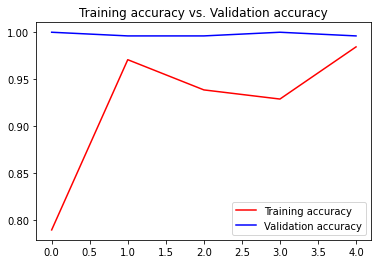

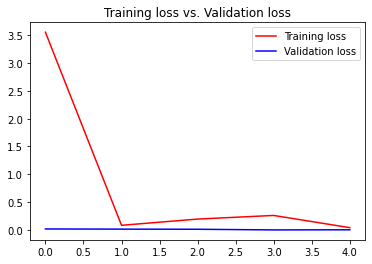

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.legend()
plt.title("Training accuracy vs. Validation accuracy")

plt.figure()

plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend()
plt.title("Training loss vs. Validation loss")

You must be thinking 
"HOW CAN THE VALIDATION ACCURACY BE SO HIGH?"
Well you have a look at the validation data, you can see that the validation images do not have any background and the training images have a background.

When feeding the validation images to your model you are lowering the bar and it is easier for the model to classify the images because they do not have a background. 